In [ ]:
!pip install tensorflow-gpu==1.15.2
!pip install numpy==1.19.5
!pip install keras==2.3.1

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Диплом/data.zip

## Preprocessing dataset

In [ ]:
def load_data(path):
  labels = pd.read_csv(os.path.join(path, 'labels_utf8.csv'), header=0, index_col=None, squeeze=True)
  #labels = labels[labels["Sex Offender"] == True]
  labels = labels[labels["Race"] != "Not Available"]
  labels = labels[labels["Race"] != "Bi-Racial"]
  labels = labels[["ID", "Sex", "Race"]]
  sex_to_idx = {'Female': 1, 'Male': 0}
  race_to_idx = {'Amer Indian': 0,
                'Asian': 0.25,
                'Black': 0.5,
                'Hispanic': 0.75,
                'White': 1}
  labels = labels.replace({"Sex": sex_to_idx})
  labels = labels.replace({"Race": race_to_idx})
  files = os.listdir(os.path.join(path, 'front'))
  imgs=[]
  for i in range(len(files)):
    if ".DS_Store" in files[i]:
      continue
    if "MACOSX" in files[i]:
      continue
    imgs.append(files[i])
  X = []
  y = []
  print(int(len(imgs)/3))
  for i in range(int(len(imgs)/3)):
    front_image = Image.open(os.path.join(path, 'front/', imgs[i]))
    front_image = front_image.convert('RGB')
    front_image = front_image.resize((128,128))
    front_image = np.array(front_image)
    id = imgs[i][:6]
    try:
      d = labels[labels.ID == id].values.tolist()[0][1:]
    except IndexError:
      continue
    X.append(front_image)
    y.append(d)
  return np.array(X), np.array(y)

def load_real_samples():
  X, trainy = load_data("data/")

  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]

# Model definition

In [ ]:
import pandas as pd
import os
from matplotlib import pyplot
import numpy as np
from numpy import expand_dims
from PIL import Image
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import tensorflow as tf

## Descriminator

In [ ]:
def define_discriminator(in_shape=(128, 128, 3), n_classes=10):
    # label input
    in_label = Input(shape=(2,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = int(in_shape[0] * in_shape[1] * in_shape[2]/2)
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], in_shape[2]))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (6, 6), strides=(2, 2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model

## Generator

In [ ]:
def define_generator(latent_dim, n_classes=10):
    dim = 32

    in_label = Input(shape=(2,))

    li = Embedding(n_classes, 50)(in_label)

    n_nodes = int(dim * dim/2)
    li = Dense(n_nodes)(li)

    li = Reshape((dim, dim, 1))(li)

    in_lat = Input(shape=(latent_dim,))

    n_nodes = 128 * dim * dim
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((dim, dim, 128))(gen)

    merge = Concatenate()([gen, li])

    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    out_layer = Conv2D(3, (7, 7), activation='tanh', padding='same')(gen)

    model = Model([in_lat, in_label], out_layer)
    print(model.summary())
    return model

## GAN

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False

    gen_noise, gen_label = g_model.input

    gen_output = g_model.output

    gan_output = d_model([gen_output, gen_label])

    model = Model([gen_noise, gen_label], gan_output)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

# Training

In [ ]:
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = ones((n_samples, 1))
    return [X, labels], y


def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = []
    for i in range(n_samples):
      new_sex = np.random.randint(n_classes)
      new_race = np.random.uniform(0,n_classes-1,1)[0]
      labels.append(np.array([new_sex, new_race]))
    labels = np.array(labels)
    return [z_input, labels]


def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = zeros((n_samples, 1))
    return [images, labels_input], y

def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('plot_line_plot_loss.png')
	pyplot.close()


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=600, n_batch=256):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    c1_hist, c2_hist, g_hist = list(), list(), list()
    for i in range(n_epochs):
        for j in range(bat_per_epo):

            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            c1_hist.append(d_loss1)

            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            c2_hist.append(d_loss2)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            g_hist.append(g_loss)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    plot_history(c1_hist, c2_hist, g_hist)
    g_model.save('cgan_generator.h5')

In [ ]:
latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=256)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 2, 50)        500         input_13[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 2, 24576)     1253376     embedding_7[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 128, 128, 3)  0                                            
___________________________________________________________________________________________

# Testing

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


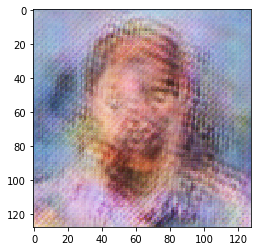

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot as plt

model = load_model('cgan_generator.h5')

n_samples = 1
latent_dim=100
labels = np.array([np.array([1, 0])])

x_input = randn(latent_dim * n_samples)
z_input = x_input.reshape(n_samples, latent_dim)

X  = model.predict([z_input, labels])
X = (X + 1) / 2.0

plt.imshow(X[0, :, :, :])